In [89]:
# Imports
import requests
import collections
import os
from os.path import join as join_path
import zipfile
import numpy as np
rng_seed = 399
np.random.seed(rng_seed)
import pickle
import pandas as pd
from tqdm.auto import tqdm
from typing import Union

import tensorflow as tf
tf.random.set_seed(rng_seed)
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Reshape, dot, Embedding
from tensorflow.keras.preprocessing.sequence import skipgrams, make_sampling_table
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence, tokenizer_from_json
from tensorflow.keras.utils import plot_model, to_categorical, Sequence, Progbar
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
wn_lemmatizer = WordNetLemmatizer()
eng_stopwords = nltk_stopwords.words('english')

from matplotlib import pyplot as plt
import plotly.express as px

# Dimensionality reduction
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Silence NumbaPerformanceWarning (for UMAP)
from numba.errors import NumbaPerformanceWarning
import warnings
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

# Clustering
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
import hdbscan

# Custom files
from importlib import reload
import utils
reload(utils)

from utils import clean_texts_to_files, create_tokenizer, read_tokenizer, read_text_files_gen, text_sequences_to_skipgrams_generator
from models import build_word2vec_model_dense

[nltk_data] Downloading package wordnet to /Users/triki/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/triki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
# Define constants
# ----------------
data_dir = 'data'
checkpoints_dir = 'checkpoints'
text8_data_path = join_path(data_dir, 'text8')
text8_data_tokenizer_config_path = join_path(data_dir, 'text8-tokenizer.json')
os.makedirs(checkpoints_dir)

# We have over 30k articles with a large vocubulary. Due to computational
# restrictions, we limit ourselves to the top 1000 words from all papers.
max_vocab_size = 1000
sampling_window_size = 5
num_negative_samples = 5
embedding_dim = 200
# ----------------

## Load dataset

In [3]:
def filter_word(word: str, lem_word: str) -> bool:
    return word not in eng_stopwords and word != '.' and len(lem_word) > 1

def clean_sents(sents_raw: list) -> list:
    print('Cleaning sentences...')
    sents = []
    for sent in tqdm(sents_raw, unit='sent'):
        sent_words = []
        for word in word_tokenize(sent):
            lem_word = wn_lemmatizer.lemmatize(word)
            
            # Filter out stopwords, period (.) and lemmatized words that are one character
            if filter_word(word, lem_word):
                sent_words.append(lem_word)
        sents.append(' '.join(sent_words))

    return sents

In [4]:
with open(text8_data_path, 'r') as file:
    text8_content = file.read()
text8_sents = sent_tokenize(text8_content)

# Remove stop words and lemmatize
text8_sents = clean_sents(text8_sents)
num_sents = len(text8_sents)

Cleaning sentences...


In [73]:
text8_sents[:1000]

['anarchism originated term abuse first used early working class radical including digger english revolution sans culotte french revolution',
 'whilst term still used pejorative way describe act used violent mean destroy organization society also taken positive label self defined anarchist',
 'word anarchism derived greek without archons ruler chief king',
 'anarchism political philosophy belief ruler unnecessary abolished although differing interpretation mean',
 'anarchism also refers related social movement advocate elimination authoritarian institution particularly state',
 'word anarchy anarchist use imply chaos nihilism anomie rather harmonious anti authoritarian society',
 'place regarded authoritarian political structure coercive economic institution anarchist advocate social relation based upon voluntary association autonomous individual mutual aid self governance',
 'anarchism easily defined anarchist also offer positive vision believe truly free society',
 'however idea anar

## Prepare dataset and split into train/val/test

In [5]:
def create_tokenizer(max_vocab_size: int, texts: Union[list, 'Generator'], save_to_file_path: str = None):
    print('Creating vocabulary...')
    tokenizer = Tokenizer(max_vocab_size, filters='', lower=False)
    tokenizer.fit_on_texts(tqdm(texts, unit='text'))

    if not save_to_file_path is None:
        with open(save_to_file_path, 'w') as file:
            file.write(tokenizer.to_json())
    
    return tokenizer

In [6]:
# Create vocabulary from texts
fit_tokenizer = False
if fit_tokenizer:
    print('Creating vocabulary...')
    
    # Here we set the filters to empty string and lower case to false
    # because we have already performed the nessecary preprocessing steps.
    tokenizer = Tokenizer(max_vocab_size, filters='', lower=False)
    tokenizer.fit_on_texts(tqdm(text8_sents, unit='text'))

    # Save to file
    with open(text8_data_tokenizer_config_path, 'w') as file:
            file.write(tokenizer.to_json())
    print('Done!')
else:
    print('Reading vocabulary...')
    
    # Read tokenizer from file
    with open(text8_data_tokenizer_config_path, 'r') as file:
        tokenizer = tokenizer_from_json(file.read())
    print('Done!')

vocab_size = np.minimum(max_vocab_size, len(tokenizer.word_index))

Reading vocabulary...
Done!


In [7]:
text8_seqs = tokenizer.texts_to_sequences(tqdm(text8_sents))

In [8]:
# Sanity checks
tokenizer.word_index['man'], tokenizer.word_index['woman']

(188, 239)

## Create Word2vec model

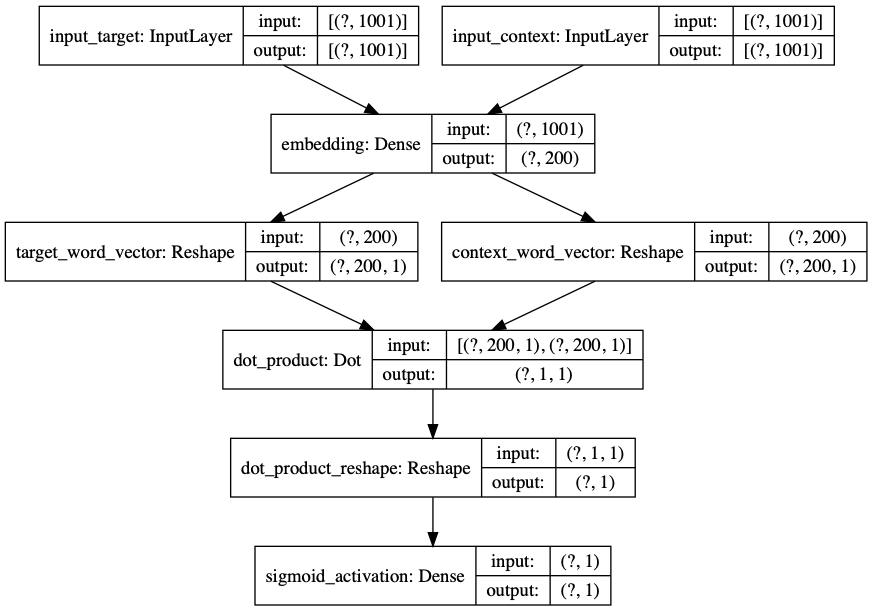

In [30]:
# Create word2vec model
model = build_word2vec_model_dense(vocab_size, embedding_dim)
plot_model(model, show_shapes=True, to_file='word2vec_model.png')

## Fit Word2vec model

In [31]:
# Define training constants
epochs = 20
batch_size = 32

In [32]:
def fit_model(model: Model,
              tokenizer: Tokenizer,
              text_seqs: list,
              epochs: int,
              batch_size: int,
              vocab_size: int,
              sampling_window_size: int,
              num_negative_samples: int,
              checkpoints_dir: str = None):
    '''
    TODO: Docs
    '''
    sampling_table = make_sampling_table(vocab_size + 1)
    train_losses = list()
    for epoch in range(1, epochs + 1):
        print(f'-- Epoch #{epoch} --')

        progbar = Progbar(len(text_seqs))
        progbar.update(0)
        
        # Training
        for i, train_text_seq in enumerate(text_seqs):
            
            # Create skipgram pairs
            data_pairs, data_labels = skipgrams(
                train_text_seq,
                vocab_size,
                sampling_table=sampling_table,
                window_size=sampling_window_size,
                negative_samples=num_negative_samples
            )
            data_pairs = np.array(data_pairs)
            data_labels = np.array(data_labels).reshape(-1, 1)

            num_skipgram_pairs = len(data_pairs)
            indices = np.arange(num_skipgram_pairs, dtype=int)
            np.random.shuffle(indices)

            # Train model in batches of skipgram pairs
            num_batches = num_skipgram_pairs // batch_size
            for batch_nr in range(num_batches):
                indices_batch = indices[batch_nr * batch_size:(batch_nr + 1) * batch_size]

                batch_pairs = list(to_categorical(data_pairs[indices_batch].T, num_classes=vocab_size + 1))
                batch_labels = data_labels[indices_batch]

                model.train_on_batch(batch_pairs, batch_labels)

            progbar.update(i + 1)
        
        ## -- intermediate epoch callback events here --
        
        # Save model to file
        if not checkpoints_dir is None:
            model_checkpoint_path = join_path(checkpoints_dir, f'word2vec-model-epoch-{epoch}.model')
            print(f'Saving model to {model_checkpoint_path}...')
            model.save(model_checkpoint_path)
            print('Done!')

In [33]:
fit_model(
    model,
    tokenizer,
    text8_seqs,
    epochs,
    batch_size,
    vocab_size,
    sampling_window_size,
    num_negative_samples,
    checkpoints_dir=checkpoints_dir
)

-- Epoch #1 --
504749/504749 [==============================] - 700s 1ms/step
Saving model to checkpoints/word2vec-model-epoch-1.model...
INFO:tensorflow:Assets written to: checkpoints/word2vec-model-epoch-1.model/assets
Done!
-- Epoch #2 --
504749/504749 [==============================] - 704s 1ms/step
Saving model to checkpoints/word2vec-model-epoch-2.model...
INFO:tensorflow:Assets written to: checkpoints/word2vec-model-epoch-2.model/assets
Done!
-- Epoch #3 --
504749/504749 [==============================] - 702s 1ms/step
Saving model to checkpoints/word2vec-model-epoch-3.model...
INFO:tensorflow:Assets written to: checkpoints/word2vec-model-epoch-3.model/assets
Done!
-- Epoch #4 --
504749/504749 [==============================] - 703s 1ms/step
Saving model to checkpoints/word2vec-model-epoch-4.model...
INFO:tensorflow:Assets written to: checkpoints/word2vec-model-epoch-4.model/assets
Done!
-- Epoch #5 --
504749/504749 [==============================] - 709s 1ms/step
Saving model t

In [74]:
epoch_nr = 20
model = load_model(f'checkpoints/word2vec-model-epoch-{epoch_nr}.model')

In [94]:
weights = model.layers[2].get_weights()[0]
weights = weights[1:] # Exclude first "junk" row
words = np.array([tokenizer.index_word[i] for i in range(1, vocab_size + 1)])

In [97]:
def similar_words_vec(word_vec: np.ndarray, weights: np.ndarray, words: list, top_n: int = 10, skip_first: int = 0):
    cos_sims = word_vec @ weights.T / (np.linalg.norm(word_vec) * np.linalg.norm(weights, axis=1))
    cos_sims = np.clip(cos_sims, 0, 1) 
    sorted_indices = cos_sims.argsort()[::-1]
    top_words = list(words[sorted_indices - 1][skip_first:skip_first + top_n])
    top_sims = cos_sims[sorted_indices][skip_first:skip_first + top_n]
    
    # Create word similarity pairs
    pairs = list(zip(top_words, top_sims))
    
    return pairs

def get_word_vec(word: str, words: list) -> np.ndarray:
    return weights[np.where(words == word)[0][0] + 1]

def similar_words(word: str, weights: np.ndarray, words: list, top_n: int = 10):
    return similar_words_vec(get_word_vec(word, words), weights, words, top_n, skip_first=1)

In [102]:
similar_words('one', weights, words)

[('five', 0.99456203),
 ('zero', 0.99433094),
 ('two', 0.9941253),
 ('four', 0.99278957),
 ('eight', 0.99271613),
 ('six', 0.99204886),
 ('three', 0.9908064),
 ('name', 0.9898102),
 ('much', 0.9886616),
 ('force', 0.9886345)]

In [103]:
# King - man + woman = ?
man_vec = get_word_vec('man', words)
woman_vec = get_word_vec('woman', words)
king_vec = get_word_vec('king', words)
queen_vec_pred = king_vec - man_vec + woman_vec
similar_words_vec(queen_vec_pred, weights, words, top_n=25)

[('woman', 0.9677767),
 ('king', 0.9663487),
 ('act', 0.95194495),
 ('brother', 0.9511959),
 ('material', 0.9507692),
 ('produced', 0.9500279),
 ('head', 0.94987255),
 ('nation', 0.94986683),
 ('award', 0.94937605),
 ('chinese', 0.94935626),
 ('war', 0.9492095),
 ('took', 0.9490398),
 ('ground', 0.948766),
 ('location', 0.94871974),
 ('canadian', 0.94870335),
 ('movement', 0.94863117),
 ('analysis', 0.94859827),
 ('force', 0.94857323),
 ('another', 0.9485628),
 ('etc', 0.94841486),
 ('family', 0.94839877),
 ('bbc', 0.94830745),
 ('america', 0.94816935),
 ('chemical', 0.9481494),
 ('control', 0.9479789)]

In [116]:
word_embeddings_3d = umap.UMAP(n_components=3, n_neighbors=5).fit_transform(weights)

In [117]:
cluster_labels = KMeans(n_clusters=10).fit_predict(weights)

In [118]:
# Visualize the words in 3D with Plotly
word_embedding_vis_df = pd.DataFrame({
    'x': word_embeddings_3d[:, 0],
    'y': word_embeddings_3d[:, 1],
    'z': word_embeddings_3d[:, 2],
    'cluster_label': cluster_labels,
    'word': words
})
fig = px.scatter_3d(word_embedding_vis_df, x='x', y='y', z='z', color='cluster_label', hover_name='word')
fig.show()

In [ ]:
# TODO: Create function for "arrow-plt"; see word_2_vec_impl notebook

In [125]:
!wget https://raw.githubusercontent.com/svn2github/word2vec/master/questions-words.txt -O data/questions-words.txt
# TODO: Check for accuracy on the question word pairs above

--2020-04-22 21:06:47--  https://raw.githubusercontent.com/svn2github/word2vec/master/questions-words.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 603955 (590K) [text/plain]
Saving to: ‘data/questions-words.txt’

data/questions-word 100%[===================>] 589.80K  --.-KB/s    in 0.1s    

2020-04-22 21:06:51 (4.70 MB/s) - ‘data/questions-words.txt’ saved [603955/603955]



# Scrapyard

In [ ]:
# Split datasets into train/val/test using a 99/1/1 split respectively.
# Each dataset will have contain skipgram pairs from a unique set of papers
# to train/evaluate on.
# train_size = 0.98
# val_size = 0.01
# test_size = 0.01
# train_indices, val_indices = train_test_split(np.arange(num_sents), train_size=train_size, random_state=rng_seed)
# val_indices, test_indices = train_test_split(val_indices, test_size=test_size / (test_size + val_size), random_state=rng_seed)

In [ ]:
class DataGenerator(Sequence):
    
    def __init__(
        self,
        text_sequences: list,
        vocab_size: int,
        sampling_window_size: int,
        num_negative_samples: int,
        sampling_factor: float = 1e-3,
        batch_size: int = 32,
        shuffle: bool = True
    ):
        self.text_sequences = text_sequences
        self.num_text_sequences = len(text_sequences)
        self.vocab_size = vocab_size
        self.sampling_window_size = sampling_window_size
        self.num_negative_samples = num_negative_samples
        self.sampling_table = make_sampling_table(vocab_size + 1, sampling_factor=sampling_factor)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.__prepare_generator()
        self.on_epoch_end()
    
    def __prepare_generator(self):
        print('Preparing data...')
        num_sequences = 0
        for sent in tqdm(self.text_sequences, unit='seq'):
            num_sequences += len(sent)
        
        # We need the maximum number of skipgram pairs
        # count to estimate the number of batches per epoch.
        self.max_skipgram_pairs = num_sequences * (self.num_negative_samples + 1)

    def __len__(self) -> int:
        'Denotes the number of batches per epoch'
        return self.max_skipgram_pairs // self.batch_size
    
    def __get_skipgrams(self, text_sequence_nr: int) -> tuple:
        text_sequence_index = self.text_sequences_indices[text_sequence_nr]
        text_seq = self.text_sequences[text_sequence_index]
        pairs, labels = skipgrams(
            text_seq,
            self.vocab_size,
            sampling_table=self.sampling_table,
            window_size=self.sampling_window_size,
            negative_samples=self.num_negative_samples
        )
        pairs = np.array(pairs)
        num_pairs = len(pairs)
        labels = np.array(labels).reshape(-1, 1)
        indices = np.arange(num_pairs, dtype=int)
        np.random.shuffle(indices)
        num_batches = num_pairs // self.batch_size
        
        return pairs, labels, indices, num_batches
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.text_sequence_nr = 0
        self.text_sequences_indices = np.arange(self.num_text_sequences)
        if self.shuffle:
            np.random.shuffle(self.text_sequences_indices)
        
        # Prepare first set of skipgram pairs
        pairs, labels, indices, num_batches = self.__get_skipgrams(self.text_sequence_nr)
        self.cur_pairs = pairs
        self.cur_labels = labels
        self.cur_indices = indices
        self.cur_batch_nr = 0
        self.cur_batches_count = num_batches

    def __getitem__(self, idx):
        'Generate one batch of data'
        
        if self.cur_batch_nr >= self.cur_batches_count:
            
            # Create new skipgrams
            self.text_sequence_nr += 1
            pairs, labels, indices, num_batches = self.__get_skipgrams(self.text_sequence_nr)
            self.cur_pairs = pairs
            self.cur_labels = labels
            self.cur_batch_nr = 0
            self.cur_batches_count = num_batches
        
        indices_batch = self.cur_indices[self.cur_batch_nr * self.batch_size:(self.cur_batch_nr + 1) * self.batch_size]
        self.cur_batch_nr += 1
        
        batch_pairs = list(to_categorical(self.cur_pairs[indices_batch].T, num_classes=self.vocab_size + 1))
        batch_labels = self.cur_labels[indices_batch]
        
        return batch_pairs, batch_labels

In [ ]:
train_gen = DataGenerator(
    text8_seqs,
    vocab_size,
    sampling_window_size,
    num_negative_samples,
    batch_size=batch_size
)

In [ ]:
model_hist = model.fit(train_gen, epochs=1)